# Time Series Exploration of Pick data

### Environment setup

In [1]:
import acquire
import prepare
import wrangle_pick
import summarize
import explore
import model

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

explore.set_plotting_defaults()

# Wrangle

In [2]:
train, test, validate = wrangle_pick.wrangle_pick_data()
train.shape, test.shape, validate.shape

Acquire: downloading raw data files...
Acquire: Completed!
Prepare: Cleaning acquired data...
Prepare: Completed!


((96644, 18), (20065, 18), (17055, 18))

In [3]:
# create df for explore
exp = train.copy()

In [4]:
# create df for time series exploration
ts = train.copy()

# Non-TS index Explore

In [29]:
exp1 = exp[['start', 'total_lines', 'total_boxes', 'pick_seconds', 'operator', 'int_day', 'sec_per_box', 'lines_per_box', 'sec_per_line' ]]

In [31]:
exp1 = exp1.set_index('start').sort_index()
exp1['month'] = exp1.index.hour
exp1['day'] = exp1.
train['month'] = train.index.month

# Time Series Explore

## Prepare time series dataframe

In [5]:
ts.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,int_day,day_name,start_year,start_month,start_Y_M,end_year,end_month,end_Y_M,sec_per_box,lines_per_box,sec_per_line
50058,IT,3,1,2016-11-10 09:58:58,2016-11-10 10:00:57,0 days 00:01:59,119.0,3,Thursday,2016,11,2016-11,2016,11,2016-11,119.0,3.0,39.666667
78958,IT,71,1,2017-08-22 08:40:42,2017-08-22 09:08:29,0 days 00:27:47,1667.0,1,Tuesday,2017,8,2017-08,2017,8,2017-08,1667.0,71.0,23.478873
72775,JS,3,1,2017-06-19 16:54:16,2017-06-19 16:58:10,0 days 00:03:54,234.0,0,Monday,2017,6,2017-06,2017,6,2017-06,234.0,3.0,78.000000
68159,IT,4,1,2017-04-27 16:51:23,2017-04-27 16:57:45,0 days 00:06:22,382.0,3,Thursday,2017,4,2017-04,2017,4,2017-04,382.0,4.0,95.500000
96678,HB,2,1,2018-03-15 12:17:11,2018-03-15 12:17:35,0 days 00:00:24,24.0,3,Thursday,2018,3,2018-03,2018,3,2018-03,24.0,2.0,12.000000


In [16]:
# create a dataframe with start as index and total lines, total boxes, and pick seconds as target
# these can all be aggregated by sum for resampling
pick = ts[['start', 'total_lines', 'total_boxes', 'pick_seconds']]
pick = pick.set_index('start').sort_index()

In [17]:
pick.head()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02 09:39:12,5,1,17.0
2016-01-02 09:42:55,2,1,22.0
2016-01-02 09:44:54,2,1,79.0
2016-01-02 09:47:42,2,1,27.0
2016-01-02 09:52:19,4,1,31.0


## Basic range and histograms

without resampling

In [18]:
pick.index.min(), pick.index.max()

(Timestamp('2016-01-02 09:39:12'), Timestamp('2019-12-24 11:08:01'))

array([[<AxesSubplot:title={'center':'total_lines'}>,
        <AxesSubplot:title={'center':'total_boxes'}>],
       [<AxesSubplot:title={'center':'pick_seconds'}>, <AxesSubplot:>]],
      dtype=object)

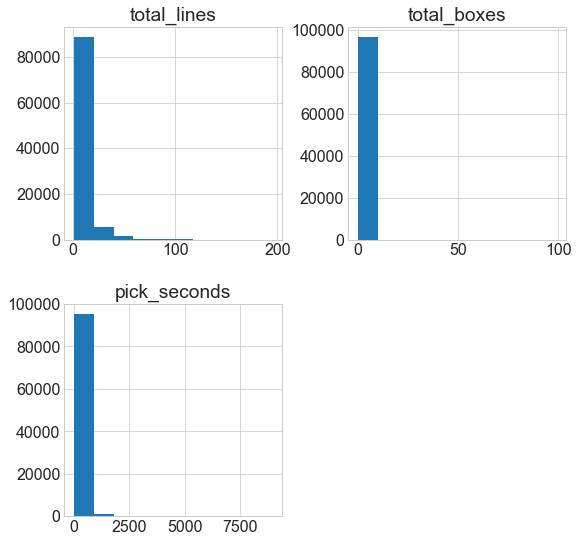

In [24]:
pick.hist(figsize=(9, 9))

<AxesSubplot:xlabel='start'>

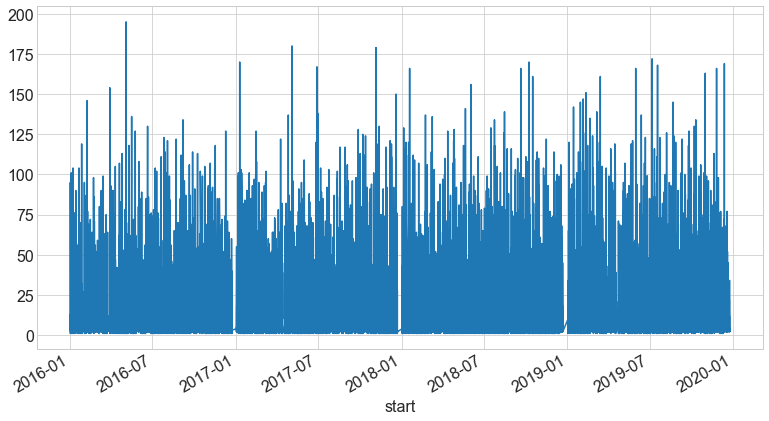

In [20]:
pick.total_lines.plot()

<AxesSubplot:xlabel='start'>

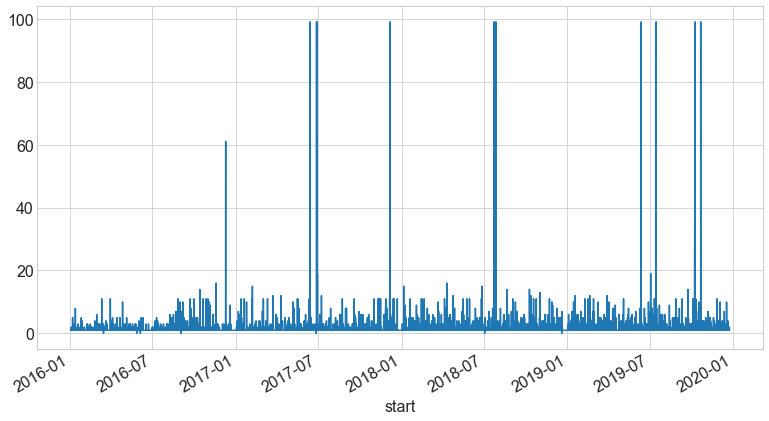

In [21]:
pick.total_boxes.plot()

<AxesSubplot:xlabel='start'>

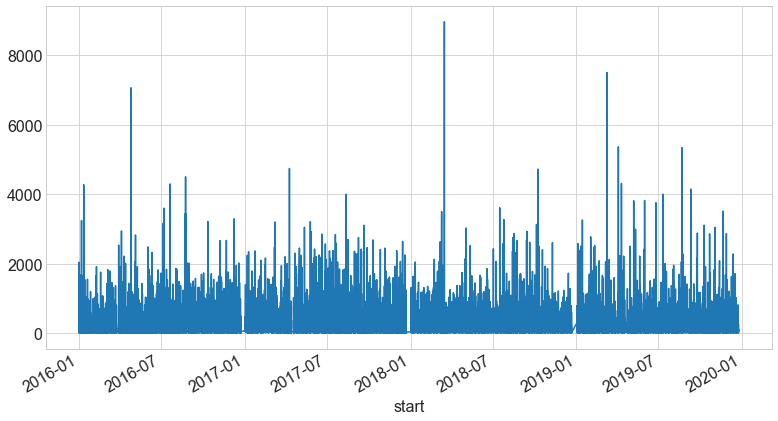

In [22]:
pick.pick_seconds.plot()

## Resample by Hour

In [27]:
pick.resample('H').sum()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02 09:00:00,34,7,406.0
2016-01-02 10:00:00,261,22,3921.0
2016-01-02 11:00:00,179,16,3439.0
2016-01-02 12:00:00,142,19,2017.0
2016-01-02 13:00:00,215,19,3384.0
...,...,...,...
2019-12-24 07:00:00,0,0,0.0
2019-12-24 08:00:00,6,2,145.0
2019-12-24 09:00:00,0,0,0.0


In [15]:
pick.isna().sum()

pick_seconds    0
dtype: int64